In [ ]:
!pip install opencv-python
!pip install tensorflow
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
from tensorflow.keras.layers import *
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.xception import Xception

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
print("Path to dataset files:", path)
print("Dataset path:", path)
print("Files and folders:", os.listdir(path))

Path to dataset files: /kaggle/input/massachusetts-roads-dataset
Dataset path: /kaggle/input/massachusetts-roads-dataset
Files and folders: ['label_class_dict.csv', 'tiff', 'metadata.csv']


In [ ]:
import os
import shutil

# Create required subdirectories
os.makedirs("/kaggle/working/train/images", exist_ok=True)
os.makedirs("/kaggle/working/train_labels/masks", exist_ok=True)

# Move training images into subfolder
for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/train"):
    if file.endswith(".tiff"):
        shutil.copy(f"/kaggle/input/massachusetts-roads-dataset/tiff/train/{file}",
                    f"/kaggle/working/train/images/{file}")

# Move training masks into subfolder
for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/train_labels"):
    if file.endswith(".tif"):
        shutil.copy(f"/kaggle/input/massachusetts-roads-dataset/tiff/train_labels/{file}",
                    f"/kaggle/working/train_labels/masks/{file}")
os.makedirs("/kaggle/working/val/images", exist_ok=True)
os.makedirs("/kaggle/working/val_labels/masks", exist_ok=True)

# Copy validation images and masks
for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/val"):
    if file.endswith(".tiff"):
        shutil.copy("/kaggle/input/massachusetts-roads-dataset/tiff/val/" + file,
                    "/kaggle/working/val/images/" + file)

for file in os.listdir("/kaggle/input/massachusetts-roads-dataset/tiff/val_labels"):
    if file.endswith(".tif"):
        shutil.copy("/kaggle/input/massachusetts-roads-dataset/tiff/val_labels/" + file,
                    "/kaggle/working/val_labels/masks/" + file)


In [ ]:
import os
import shutil

# Create class subdirectories
os.makedirs("/kaggle/working/train/images/road", exist_ok=True)
os.makedirs("/kaggle/working/train_labels/masks/road", exist_ok=True)
os.makedirs("/kaggle/working/val/images/road", exist_ok=True)
os.makedirs("/kaggle/working/val_labels/masks/road", exist_ok=True)

# Move training images
source_train_images = "/kaggle/working/train/images"
dest_train_images = "/kaggle/working/train/images/road"
for file in os.listdir(source_train_images):
    if file.endswith(".tiff"):
        shutil.move(os.path.join(source_train_images, file), os.path.join(dest_train_images, file))

# Move training masks
source_train_masks = "/kaggle/working/train_labels/masks"
dest_train_masks = "/kaggle/working/train_labels/masks/road"
for file in os.listdir(source_train_masks):
    if file.endswith(".tif"):
        shutil.move(os.path.join(source_train_masks, file), os.path.join(dest_train_masks, file))

# Move validation images
source_val_images = "/kaggle/working/val/images"
dest_val_images = "/kaggle/working/val/images/road"
for file in os.listdir(source_val_images):
    if file.endswith(".tiff"):
        shutil.move(os.path.join(source_val_images, file), os.path.join(dest_val_images, file))

# Move validation masks
source_val_masks = "/kaggle/working/val_labels/masks"
dest_val_masks = "/kaggle/working/val_labels/masks/road"
for file in os.listdir(source_val_masks):
    if file.endswith(".tif"):
        shutil.move(os.path.join(source_val_masks, file), os.path.join(dest_val_masks, file))

print("Directory structure reorganized for flow_from_directory.")

Directory structure reorganized for flow_from_directory.


In [ ]:
def TrainGenerator_Revised(aug_dict, image_folder, mask_folder, batch_size, seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        directory=image_folder,
        target_size=(512, 512),
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_directory(
        directory=mask_folder,
        target_size=(512, 512),
        color_mode='grayscale',
        class_mode=None,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    while True:
        img = next(image_generator)  # Use next() directly
        mask = next(mask_generator)   # Use next() directly
        mask = mask / 255.0
        mask = np.reshape(mask, (mask.shape[0], 512, 512, 1))
        yield img, mask

def ValGenerator_Revised(aug_dict, image_folder, mask_folder, batch_size, seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        directory=image_folder,
        target_size=(512, 512),
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_directory(
        directory=mask_folder,
        target_size=(512, 512),
        color_mode='grayscale',
        class_mode=None,
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    while True:
        img = next(image_generator)  # Use next() directly
        mask = next(mask_generator)   # Use next() directly
        mask = mask / 255.0
        mask = np.reshape(mask, (mask.shape[0], 512, 512, 1))
        yield img, mask

In [ ]:
data_gen_args = dict()
Generator = TrainGenerator_Revised(
    aug_dict=data_gen_args,
    image_folder='/kaggle/working/train/images',  # Point to the parent of 'road'
    mask_folder='/kaggle/working/train_labels/masks', # Point to the parent of 'road'
    batch_size=4,
    seed=1
)

Val = ValGenerator_Revised(
    aug_dict=data_gen_args,
    image_folder='/kaggle/working/val/images',    # Point to the parent of 'road'
    mask_folder='/kaggle/working/val_labels/masks',   # Point to the parent of 'road'
    batch_size=4,
    seed=1
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
temp_generator = TrainGenerator_Revised(data_gen_args, '/kaggle/working/train/images', '/kaggle/working/train_labels/masks', batch_size=4)
sample_x, sample_y = next(temp_generator)
print("Sample X shape:", sample_x.shape)
print("Sample Y shape:", sample_y.shape)
print("Sample Y dtype:", sample_y.dtype)

Found 1108 images belonging to 1 classes.
Found 1108 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


Sample X shape: (4, 512, 512, 3)
Sample Y shape: (4, 512, 512, 1)
Sample Y dtype: float32


In [ ]:
temp_val = ValGenerator_Revised(data_gen_args, '/kaggle/working/val/images', '/kaggle/working/val_labels/masks', batch_size=4)
sample_val_x, sample_val_y = next(temp_val)
print("Sample Val X shape:", sample_val_x.shape)
print("Sample Val Y shape:", sample_val_y.shape)
print("Sample Val Y dtype:", sample_val_y.dtype)

Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.
Sample Val X shape: (4, 512, 512, 3)
Sample Val Y shape: (4, 512, 512, 1)
Sample Val Y dtype: float32


In [ ]:
import os
train_image_dir = '/kaggle/working/train/images/road'
print("Contents of training image directory:")
print(os.listdir(train_image_dir))

Contents of training image directory:
['19678660_15.tiff', '21928945_15.tiff', '26128705_15.tiff', '24778885_15.tiff', '21778930_15.tiff', '26429275_15.tiff', '21628885_15.tiff', '23729065_15.tiff', '24328855_15.tiff', '11278765_15.tiff', '18328930_15.tiff', '22529080_15.tiff', '19078765_15.tiff', '23128990_15.tiff', '10978675_15.tiff', '16378840_15.tiff', '24179065_15.tiff', '24329050_15.tiff', '17578870_15.tiff', '99238675_15.tiff', '23128870_15.tiff', '21328885_15.tiff', '11578825_15.tiff', '20578915_15.tiff', '22829410_15.tiff', '24329260_15.tiff', '17428735_15.tiff', '23728975_15.tiff', '17878870_15.tiff', '23428570_15.tiff', '22679485_15.tiff', '23128975_15.tiff', '27028705_15.tiff', '11278795_15.tiff', '17428780_15.tiff', '11578795_15.tiff', '12328765_15.tiff', '19828630_15.tiff', '18178945_15.tiff', '23879200_15.tiff', '24628870_15.tiff', '23729230_15.tiff', '23729095_15.tiff', '21178945_15.tiff', '25379230_15.tiff', '11128855_15.tiff', '23728810_15.tiff', '15928885_15.tiff', '

In [ ]:
train_mask_dir = '/kaggle/working/train_labels/masks/road'
print("Contents of training mask directory:")
print(os.listdir(train_mask_dir))

Contents of training mask directory:
['24329185_15.tif', '23429065_15.tif', '17878945_15.tif', '21929050_15.tif', '26278750_15.tif', '26279260_15.tif', '20128915_15.tif', '18328795_15.tif', '17128885_15.tif', '23428975_15.tif', '23878990_15.tif', '25379260_15.tif', '25979275_15.tif', '12628810_15.tif', '18028765_15.tif', '24628795_15.tif', '23279170_15.tif', '25079200_15.tif', '23729005_15.tif', '18028795_15.tif', '11728840_15.tif', '20578990_15.tif', '16378825_15.tif', '25229185_15.tif', '17428735_15.tif', '18778780_15.tif', '23128990_15.tif', '17578915_15.tif', '20428900_15.tif', '25829260_15.tif', '20128870_15.tif', '18628915_15.tif', '22828900_15.tif', '23879200_15.tif', '10678690_15.tif', '24179080_15.tif', '23128975_15.tif', '10528690_15.tif', '10378690_15.tif', '26429245_15.tif', '23279020_15.tif', '23429095_15.tif', '22979455_15.tif', '23279080_15.tif', '17878720_15.tif', '15928900_15.tif', '22978855_15.tif', '23578600_15.tif', '15778825_15.tif', '24779245_15.tif', '22828870_15

Found 1108 images belonging to 1 classes.
Found 1108 images belonging to 1 classes.


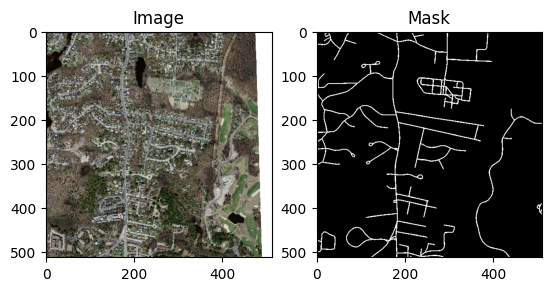

In [ ]:
x, y = next(Generator)
plt.subplot(1, 2, 1)
plt.imshow(x[3]/ 255.0)
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(y[3].squeeze(), cmap='gray')
plt.title("Mask")
plt.show()

In [ ]:
def channel_attention_module(inputs, reduction_ratio=16):
    channel = inputs.shape[-1]
    gap = layers.GlobalAveragePooling2D()(inputs)
    gap = layers.ReLU()(gap)
    dense1 = layers.Dense(channel // reduction_ratio, activation='relu')(gap)
    dense2 = layers.Dense(channel, activation='sigmoid')(dense1)
    scale = layers.Multiply()([inputs, layers.Reshape((1, 1, channel))(dense2)])
    return scale


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def UNet_CAM(input_shape=(512, 512, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(conv4)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    conv3_cam = channel_attention_module(conv3)
    merge5 = layers.concatenate([conv3_cam, up5], axis=-1)
    conv5 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(merge5)
    conv5 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    conv2_cam = channel_attention_module(conv2)
    merge6 = layers.concatenate([conv2_cam, up6], axis=-1)
    conv6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(merge6)
    conv6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    conv1_cam = channel_attention_module(conv1)
    merge7 = layers.concatenate([conv1_cam, up7], axis=-1)
    conv7 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(merge7)
    conv7 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(conv7)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(conv7)

    model = Model(inputs, outputs)
    return model


In [ ]:
model = UNet_CAM(input_shape=(512, 512, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Instantiate the model
model = UNet_CAM(input_shape=(512, 512, 3))

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', mode='min', factor=0.5, patience=10,
    verbose=1, cooldown=1, min_delta=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=20,
    verbose=1, mode='min', restore_best_weights=True
)

check_path = '/content/drive/My Drive/CAM7/Weights/UNet_CAM.weights.h5'
os.makedirs(os.path.dirname(check_path), exist_ok=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path, monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True, mode='min'
)

# Train
history = model.fit(
    Generator,
    steps_per_epoch=277,  # Adjust based on dataset size / batch
    epochs=15,
    validation_data=Val,
    validation_steps=4,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9477 - loss: 0.2237Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 0.19797, saving model to /content/drive/My Drive/CAM7/Weights/UNet_CAM.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 288s 811ms/step - accuracy: 0.9477 - loss: 0.2236 - val_accuracy: 0.9318 - val_loss: 0.1980 - learning_rate: 1.0000e-04
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9517 - loss: 0.1575
Epoch 2: val_loss improved from 0.19797 to 0.17201, saving model to /content/drive/My Drive/CAM7/Weights/UNet_CAM.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 192s 694ms/step - accuracy: 0.9517 - loss: 0.1574 - val_accuracy: 0.9380 - val_loss: 0.1720 - learning_rate: 1.0000e-04
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9576 - loss: 0.1342
Epoch 3: val_loss improved from 0.17201 to 0.15865, saving model to /content/drive/My Drive/CAM7/Weights/UNet_CA

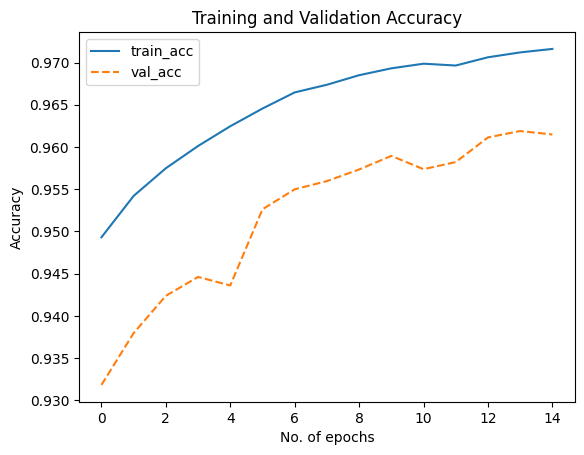

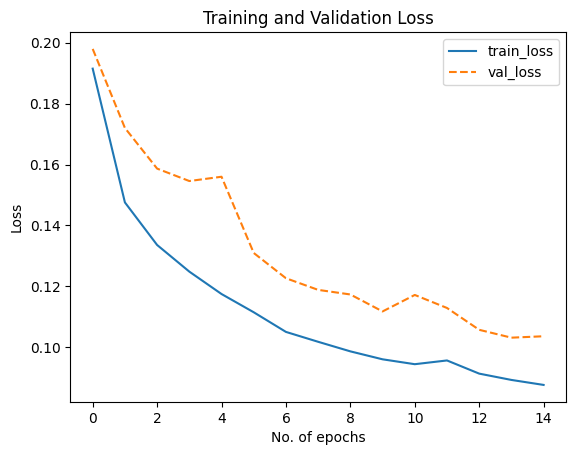

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], '--', label='val_acc')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], '--', label='val_loss')
    plt.legend()
    plt.xlabel("No. of epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()

plot_history(history)

In [ ]:
import time
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Import OpenCV for resizing

# Path to your TIFF image
imageA = '/kaggle/working/val_labels/masks/road/23128930_15.tif'
GT='/kaggle/working/val/images/road/10228690_15.tiff'

# Read the TIFF image using tifffile
x1 = tiff.imread(imageA)

# Check the shape of the image
print(f"Original Image Shape: {x1.shape}")

# Resize the image to 512x512 using OpenCV
x1 = cv2.resize(x1, (512, 512))  # Resize to 512x512

# Reshape to (1, 512, 512, 1) for grayscale image # Change is here
a = np.reshape(x1, (1, 512, 512, 1)) # Change is here: Reshape to (1, 512, 512, 1) since it is a grayscale image

# Convert to 3 channels if your model requires it
# If your model expects 3 channels, you can repeat the grayscale channel 3 times
a = np.repeat(a, 3, axis=-1)  # Repeat grayscale channel to create 3 channels
# a = tf.image.grayscale_to_rgb(tf.convert_to_tensor(a)) # You can also use this tensorflow method to change your image to RGB


# Measure the time before making a prediction
t1 = time.time()

# Predict using your model
y = model.predict(a)

# Measure the time after the prediction
t2 = time.time()

# Print the time taken for prediction
print(f"Time taken for prediction: {t2 - t1} seconds")

Original Image Shape: (1500, 1500)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Time taken for prediction: 9.005190372467041 seconds


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


<Figure size 640x480 with 0 Axes>

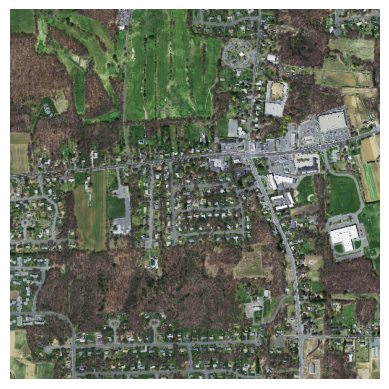

Model output (before thresholding): 1.9159732e-13 0.9984706
Ground truth values (min, max): 0 255


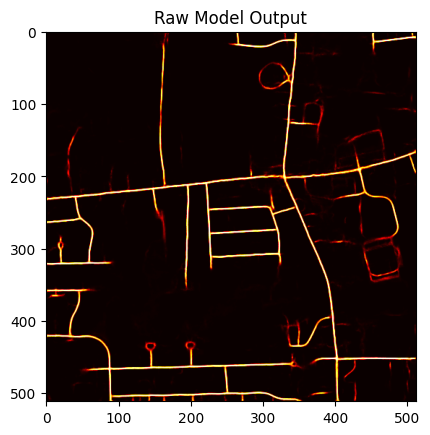

In [ ]:
imageA = '/kaggle/working/val/images/road/10228690_15.tiff'
gt = '/kaggle/working/val_labels/masks/road/10228690_15.tif'
# res_dir = 'G:/Segmentation _Multisensor/road/CartoRoadNet/images/CH'
x1 = tiff.imread(imageA)
x2 = tiff.imread(gt)

# Resize the image before reshaping
x1 = cv2.resize(x1, (512, 512))
# Resize the ground truth mask as well to match the image size
x2 = cv2.resize(x2, (512, 512))  # Add this line to resize x2

a = np.reshape(x1,(1,512,512,3))
y = model.predict(a)
y = np.reshape(y,(512,512))
result = np.where(y>0.5,1,0)
fig = plt.figure()
fig.figsize = (30,30)

fig, ax = plt.subplots()
a = ax.imshow(np.reshape(x1,(512,512,3)))
plt.axis('off')
# fig.savefig(os.path.join(res_dir, 'img_ch1.jpg'),bbox_inches='tight')
plt.show()

print("Model output (before thresholding):", np.min(y), np.max(y))
print("Ground truth values (min, max):", np.min(x2), np.max(x2))
result = np.where(y > 127, 1, 0)  # if values are in [0, 255]
plt.imshow(y, cmap="hot")
plt.title("Raw Model Output")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


<Figure size 640x480 with 0 Axes>

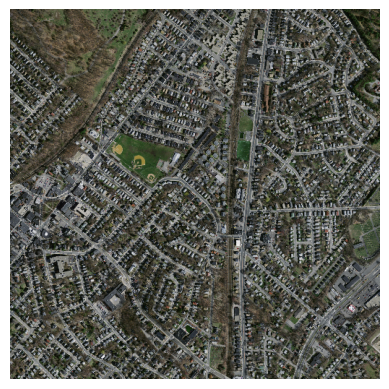

Model output (before thresholding): 7.3185305e-08 0.99975437
Ground truth values (min, max): 0 255


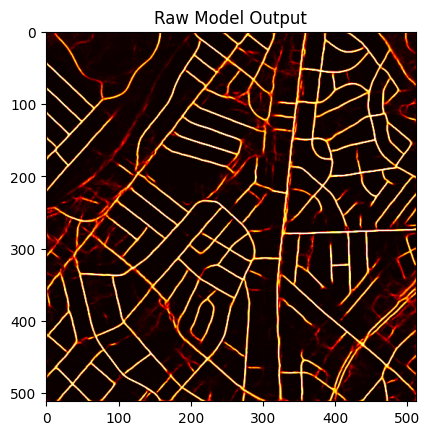

In [ ]:
imageA = '/kaggle/working/val/images/road/23128930_15.tiff'
gt = '/kaggle/working/val_labels/masks/road/23128930_15.tif'
# res_dir = 'G:/Segmentation _Multisensor/road/CartoRoadNet/images/CH'
x1 = tiff.imread(imageA)
x2 = tiff.imread(gt)

# Resize the image before reshaping
x1 = cv2.resize(x1, (512, 512))
# Resize the ground truth mask as well to match the image size
x2 = cv2.resize(x2, (512, 512))  # Add this line to resize x2

a = np.reshape(x1,(1,512,512,3))
y = model.predict(a)
y = np.reshape(y,(512,512))
result = np.where(y>0.5,1,0)
fig = plt.figure()
fig.figsize = (30,30)

fig, ax = plt.subplots()
a = ax.imshow(np.reshape(x1,(512,512,3)))
plt.axis('off')
# fig.savefig(os.path.join(res_dir, 'img_ch1.jpg'),bbox_inches='tight')
plt.show()

print("Model output (before thresholding):", np.min(y), np.max(y))
print("Ground truth values (min, max):", np.min(x2), np.max(x2))
result = np.where(y > 127, 1, 0)  # if values are in [0, 255]
plt.imshow(y, cmap="hot")
plt.title("Raw Model Output")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


<Figure size 640x480 with 0 Axes>

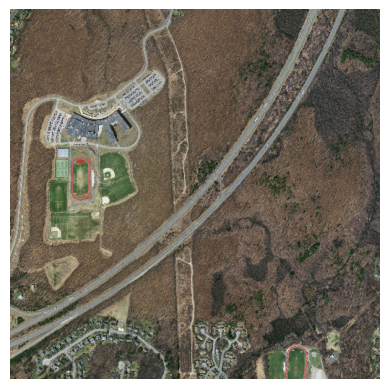

In [ ]:
imageA = '/kaggle/working/val/images/road/18028945_15.tiff'
gt = '/kaggle/working/val_labels/masks/road/18028945_15.tif'
# res_dir = 'G:/Segmentation _Multisensor/road/CartoRoadNet/images/CH'
x1 = tiff.imread(imageA)
x2 = tiff.imread(gt)

# Resize the image before reshaping
x1 = cv2.resize(x1, (512, 512))
# Resize the ground truth mask as well to match the image size
x2 = cv2.resize(x2, (512, 512))  # Add this line to resize x2

a = np.reshape(x1,(1,512,512,3))
y = model.predict(a)
y = np.reshape(y,(512,512))
result = np.where(y>0.5,1,0)
fig = plt.figure()
fig.figsize = (30,30)

fig, ax = plt.subplots()
a = ax.imshow(np.reshape(x1,(512,512,3)))
plt.axis('off')
# fig.savefig(os.path.join(res_dir, 'img_ch1.jpg'),bbox_inches='tight')
plt.show()

Model output (before thresholding): 5.6717686e-10 0.9904184
Ground truth values (min, max): 0 255


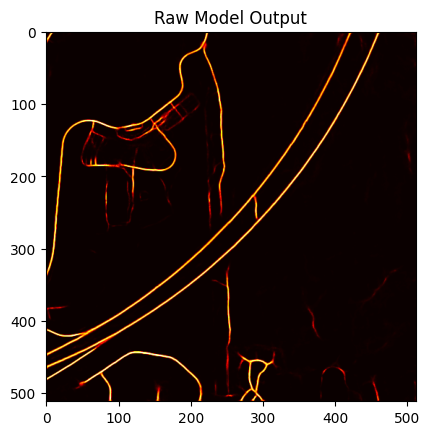

In [ ]:
print("Model output (before thresholding):", np.min(y), np.max(y))
print("Ground truth values (min, max):", np.min(x2), np.max(x2))
result = np.where(y > 127, 1, 0)  # if values are in [0, 255]
plt.imshow(y, cmap="hot")
plt.title("Raw Model Output")
plt.show()

In [ ]:
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix

# Helper: Preprocess and load masks
def load_mask(path, target_size=(512, 512)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = (mask > 127).astype(np.uint8)  # Binarize
    return mask

# Collect predictions and GTs
gt_dir = '/kaggle/working/val_labels/masks/road'
img_dir = '/kaggle/working/val/images/road'

gt_list = sorted(os.listdir(gt_dir))
img_list = sorted(os.listdir(img_dir))

y_true_flat = []
y_pred_flat = []

for fname in gt_list:
    # Load GT
    gt = load_mask(os.path.join(gt_dir, fname))

    # Load corresponding image and predict
    img = cv2.imread(os.path.join(img_dir, fname.replace('.tif', '.tiff')))
    img = cv2.resize(img, (512, 512)) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0, :, :, 0]
    pred = (pred > 0.5).astype(np.uint8)

    # Flatten and add
    y_true_flat.extend(gt.flatten())
    y_pred_flat.extend(pred.flatten())

# Convert to np.array
y_true_flat = np.array(y_true_flat)
y_pred_flat = np.array(y_pred_flat)

# Now compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
kappa, iou, acc, F1 = parameters(cm, classes=[0, 1])

print("k = ", kappa)
print("iou = ", iou)
print("acc = ", acc)
print("F1 = ", F1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
k =  [np.float64(0.0), np.float64(0.0)]
iou =  [np.float64(0.9309349060058594), np.float64(0.0)]
acc =  [np.float64(0.9309349060058594), np.float64(0.9309349060058594)]
F1 =  [np.float64(0.9642323033369354), 0]
